In [228]:
import pm4py
import pandas as pd
from pm4py.visualization.petri_net import visualizer as pn_viz
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn import converter as bpmn_converter
from pm4py.statistics.variants.log import get as variants_get
from pm4py.algo.evaluation.simplicity import algorithm as simp_eval
from pm4py.algo.evaluation.generalization import algorithm as gen_eval
from pm4py.algo.evaluation.precision import algorithm as prec_eval
from pm4py.algo.conformance.tokenreplay import algorithm as tr
from pm4py.algo.evaluation.replay_fitness.variants import token_replay as rf_token



log = pm4py.read_xes('/Users/simonimmler/PycharmProjects/Praktikum/data/BPI Challenge 2017.xes') # Todo: Change
df  = pm4py.convert_to_dataframe(log)

# not used for the final model but helped for understand
#df = (df.dropna(subset=["case:concept:name","time:timestamp"])
        #.assign(ts=pd.to_datetime(df["time:timestamp"], utc=True, errors="coerce"))
        #.dropna(subset=["ts"])
        #.sort_values(["case:concept:name","ts"]))
        
# Todo: to run the code on the unfiltered log comment out this code
if "lifecycle:transition" in df.columns:
  df = df[df["lifecycle:transition"].eq("complete")]
  
elog = pm4py.convert_to_event_log(df)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [229]:
variants = variants_get.get_variants(elog)
sorted_variants = sorted(variants.items(),key=lambda item: len(item[1]),reverse=True)
print("Top 10 variants:")
for variant, trace_list in sorted_variants[:10]:
    print(f"{variant} {len(trace_list)}")


Top 10 variants:
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 2209
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 1917
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') 1578
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') 969
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') 676
('A_Crea

In [230]:
bpmn = bpmn_importer.apply("../models/BPMN.bpmn")
net_bpmn, imap_bpmn, fmap_bpmn = bpmn_converter.apply(bpmn)


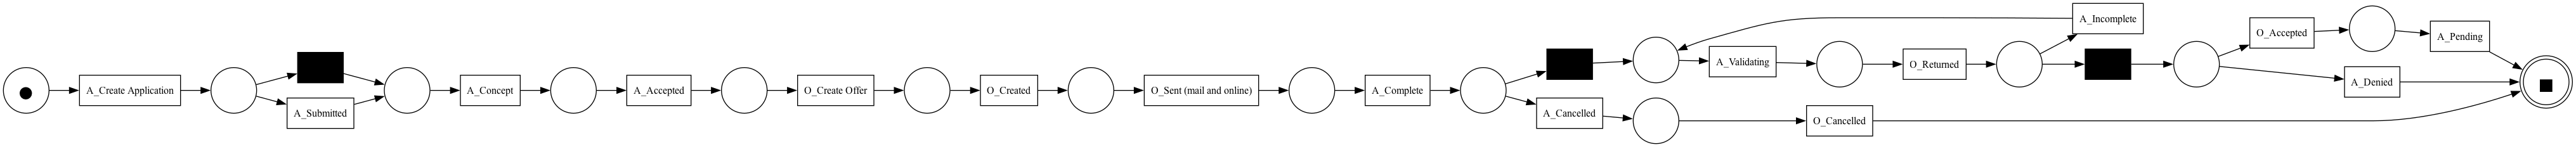

In [231]:
gviz = pn_viz.apply(net_bpmn, imap_bpmn, fmap_bpmn)   
pn_viz.view(gviz)                      
#pn_viz.save(gviz, "../figures/bpmnpetri.png")  

Fitness

Token Replay based Fitness

In [232]:
res = rf_token.apply(elog, net_bpmn, imap_bpmn, fmap_bpmn)
res

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'perc_fit_traces': 39.255450823574215,
 'average_trace_fitness': 0.9259126770608963,
 'log_fitness': 0.9097817837382126,
 'percentage_of_fitting_traces': 39.255450823574215}

Alignment based Fitness

In [233]:

from pm4py.algo.evaluation.replay_fitness.variants import alignment_based as rf_align
res_align = rf_align.apply(elog, net_bpmn, imap_bpmn, fmap_bpmn)  
print(res_align)

aligning log, completed variants ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'percFitTraces': 10.36846615252785, 'averageFitness': 0.8619602539606057, 'percentage_of_fitting_traces': 10.36846615252785, 'average_trace_fitness': 0.8619602539606057, 'log_fitness': 0.8442431565888437}


Precision

In [235]:
precision = prec_eval.apply(
    elog, net_bpmn, imap_bpmn, fmap_bpmn,
    variant=prec_eval.Variants.ETCONFORMANCE_TOKEN
)

print("Precision:", precision)

replaying log with TBR, completed traces ::   0%|          | 0/27816 [00:00<?, ?it/s]

Precision: 0.9694858416158318



Generalization

In [236]:
generalization = gen_eval.apply(elog, net_bpmn, imap_bpmn, fmap_bpmn)
print("Generalization:", generalization)

replaying log with TBR, completed traces ::   0%|          | 0/5623 [00:00<?, ?it/s]

Generalization: 0.9927364579118559


PM4PY Simplicity Metrics

In [237]:
results = {
    "arc_degree": simp_eval.apply(net_bpmn, variant=simp_eval.Variants.SIMPLICITY_ARC_DEGREE),
    "extended_cardoso": simp_eval.apply(net_bpmn, variant=simp_eval.Variants.EXTENDED_CARDOSO),
}

print("Simplicity (Arc Degree):      ", results["arc_degree"])
print("Simplicity (Extended Cardoso):", results["extended_cardoso"])

Simplicity (Arc Degree):       0.853658536585366
Simplicity (Extended Cardoso): 18


Own Simplicity Metrics (required by assignment)

In [238]:
def simplicity_size(net_bpmn):
    return len(net_bpmn.places) + len(net_bpmn.transitions)


def simplicity_edge_density(net_bpmn):
    
    P = len(net_bpmn.places)
    T = len(net_bpmn.transitions)
    A = len(net_bpmn.arcs)
    return A / max(P + T, 1)


def simplicity_invisible_share(net_bpmn):
    invisible = sum(1 for t in net_bpmn.transitions if not t.label)
    return invisible / max(len(net_bpmn.transitions), 1)


def compute_simplicity(net_bpmn):
    return {
        "size": simplicity_size(net_bpmn),
        "edge_density": simplicity_edge_density(net_bpmn),
        "invisible_share": simplicity_invisible_share(net_bpmn)
    }


simp_im = compute_simplicity(net_bpmn)
print("Own Simplicity Metrics:", simp_im)



Own Simplicity Metrics: {'size': 35, 'edge_density': 1.0857142857142856, 'invisible_share': 0.15789473684210525}


In [239]:
parameters = {
    tr.Variants.TOKEN_REPLAY.value.Parameters.ACTIVITY_KEY: "concept:name",
    tr.Variants.TOKEN_REPLAY.value.Parameters.CASE_ID_KEY: "case:concept:name",
}

replayed_traces = tr.apply(log, net_bpmn, imap_bpmn, fmap_bpmn, parameters=parameters)

total_missing = 0
total_remaining = 0
total_consumed = 0
total_produced = 0

for t in replayed_traces:
    total_missing += t["missing_tokens"]
    total_remaining += t["remaining_tokens"]
    total_consumed += t["consumed_tokens"]
    total_produced += t["produced_tokens"]

# formel:
# f = 1/2 * (1 - sum(m)/sum(c)) + 1/2 * (1 - sum(r)/sum(p))

term1 = 1 - (total_missing / total_consumed) if total_consumed  > 0 else 0
term2 = 1 - (total_remaining / total_produced) if total_produced > 0 else 0

fitness_manual = 0.5 * (term1 + term2)

print("Token-based fitness (manual):", fitness_manual)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

Token-based fitness (manual): 0.9097817837382126
